In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pdb
from mpl_toolkits.mplot3d import Axes3D
import time
import tracemalloc

In [ ]:
class RBFKernel2D(nn.Module):
    def __init__(self, init_lengthscale=1.0, init_variance=1.0):
        super(RBFKernel2D, self).__init__()
        self.lengthscale = torch.nn.Parameter(torch.tensor(init_lengthscale))
        self.variance = torch.nn.Parameter(torch.tensor(init_variance))

    def forward(self, X1, X2):
        """Compute the RBF kernel between two sets of 3D inputs."""
        diff = X1 - X2
        dist_sq = diff.pow(2).sum(-1)
        return (self.variance**2) * torch.exp(-0.5 * dist_sq / (self.lengthscale**2))


class PDEBoundaryOperators2D(torch.nn.Module):
    def __init__(self, kernel):
        super(PDEBoundaryOperators2D, self).__init__()
        self.kernel = kernel
        self.hess_diag_fnx2 = lambda x1,x2: torch.diag(torch.func.hessian(self.kernel, argnums=1)(x1,x2))
        self.grad_fnx2 = lambda x1,x2: torch.vmap(torch.vmap(torch.func.grad(kernel, argnums=1), in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.hess_fnx2 = lambda x1,x2: torch.vmap(torch.vmap(self.hess_diag_fnx2, in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.grad_fnx1 = lambda x1,x2: torch.vmap(torch.vmap(torch.func.grad(kernel, argnums=0), in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)
        self.hess_diag_fnx1 = lambda x1,x2: torch.diag(torch.func.hessian(self.kernel, argnums=0)(x1,x2))
        self.hess_fnx1 = lambda x1,x2: torch.vmap(torch.vmap(self.hess_diag_fnx1, in_dims=(0, 0)), in_dims=(0, 0))(x1, x2)

    def apply_pde_operator(self, X1, X2):
        """Apply the PDE operator L to X1 and L^T to X2."""
        X1_expand = X1.unsqueeze(1).repeat(1, X2.size(0),1).requires_grad_(True)
        X2_expand = X2.unsqueeze(0).repeat(X1.size(0), 1,1).requires_grad_(True)
        return self.operator_lx1lx2(X1_expand, X2_expand).detach()

    def apply_lb_operator(self, X1, Xb):
        """Apply the PDE operator L to X1 and boundary operator B to Xb."""
        X1_expand = X1.unsqueeze(1).repeat(1, Xb.size(0),1)
        Xb_expand = Xb.unsqueeze(0).repeat(X1.size(0), 1,1)
        hessian_K_x1 = self.hess_fnx1(X1_expand, Xb_expand)
        L_K_x1 = hessian_K_x1[:, :, 0] + hessian_K_x1[:, :, 1] + hessian_K_x1[:, :, 2]
        return L_K_x1.detach()

    def apply_boundary_operator(self, X1, Xb):
        """Apply boundary operator B for boundary points."""
        X1_expand = X1.unsqueeze(1).repeat(1, Xb.size(0),1)
        Xb_expand = Xb.unsqueeze(0).repeat(X1.size(0), 1,1)
        K = self.kernel(X1_expand, Xb_expand)
        return K

    def operator_lx2(self, X1, X2):
        hessian_K_x2 = self.hess_fnx2(X1, X2)
        return hessian_K_x2[:, :, 0] + hessian_K_x2[:, :, 1] + hessian_K_x2[:, :, 2]

    def operator_lx1lx2(self, X1, X2):
        hess_diag_lx1lx2 = lambda x1,x2: torch.diag(torch.func.hessian(self.hess_funcx2, argnums=0)(x1,x2))
        hess = torch.vmap(torch.vmap(hess_diag_lx1lx2, in_dims=(0, 0)), in_dims=(0, 0))(X1, X2)
        return hess[:, :, 0] + hess[:, :, 1] + hess[:, :, 2]

    def hess_funcx2(self, X1, X2):
        hess_op = self.hess_diag_fnx2(X1, X2)
        return torch.sum(hess_op)


class PosteriorSolver2D(nn.Module):
    def __init__(self, kernel, operators, noise_variance=1e-4):
        super(PosteriorSolver2D, self).__init__()
        self.kernel = kernel
        self.operators = operators
        self.noise_variance = noise_variance

    def compute_covariance_matrix(self, Xi, Xb):
        """Construct the covariance matrix C."""
        Xi_clone = Xi.clone().detach()
        Xb_clone = Xb.clone().detach()

        C_ii = self.operators.apply_pde_operator(Xi, Xi_clone)
        C_ib_dirichlet = self.operators.apply_lb_operator(Xi, Xb)
        C_bb_dirichlet = self.operators.apply_boundary_operator(Xb, Xb_clone)

        C_full = torch.cat([torch.cat([C_ii, C_ib_dirichlet], dim=1),
                            torch.cat([C_ib_dirichlet.T, C_bb_dirichlet], dim=1)], dim=0)
        return C_full

    def compute_covariance_vector(self, x, Xi, Xb):
        """Compute the covariance vector c(x)."""
        x_expand = x.unsqueeze(1).repeat(1, Xi.size(0),1).requires_grad_(True)
        xb_expand = x.unsqueeze(1).repeat(1,Xb.size(0),1)
        Xi_expand = Xi.unsqueeze(0).repeat(x.size(0), 1,1).requires_grad_(True)
        Xb_expand = Xb.unsqueeze(0).repeat(x.size(0), 1,1)
        L_K_x = self.operators.operator_lx2(x_expand, Xi_expand)
        B_K_x_dirichlet = self.kernel(xb_expand, Xb_expand)
        return torch.cat((L_K_x.detach(), B_K_x_dirichlet.detach()), dim=1)

    def posterior_mean(self, x, Xi, Xb, C_inv, y):
        """Compute the posterior mean."""
        c_x = self.compute_covariance_vector(x, Xi, Xb)
        return c_x @ C_inv @ y

    def posterior_mean_sdd(self, x, Xi, Xb, A_approx):
        """Compute the posterior mean using SDD approximation."""
        c_x = self.compute_covariance_vector(x, Xi, Xb)
        return c_x @ A_approx

    def posterior_covariance(self, x, x_prime, Xi, Xb, C_inv):
        """Compute the posterior covariance."""
        c_x = self.compute_covariance_vector(x, Xi, Xb)
        x_expand = x.unsqueeze(1).repeat(1, x_prime.size(0),1)
        x_prime_expand = x_prime.unsqueeze(0).repeat(x.size(0), 1,1)
        base_cov = self.kernel(x_expand, x_prime_expand)
        c_x_cinv_cxprime = c_x @ C_inv @ c_x.T
        posterior_cov = base_cov - c_x_cinv_cxprime
        return posterior_cov

    def posterior_covariance_sdd(self, x, x_prime, cov_vec, A_approx):
        """Compute the posterior covariance using SDD approximation."""
        x_expand = x.unsqueeze(1).repeat(1, x_prime.size(0),1)
        x_prime_expand = x_prime.unsqueeze(0).repeat(x.size(0), 1,1)
        base_cov = self.kernel(x_expand, x_prime_expand)
        c_x_cinv_cxprime = cov_vec @ A_approx
        posterior_cov = base_cov - c_x_cinv_cxprime
        return posterior_cov

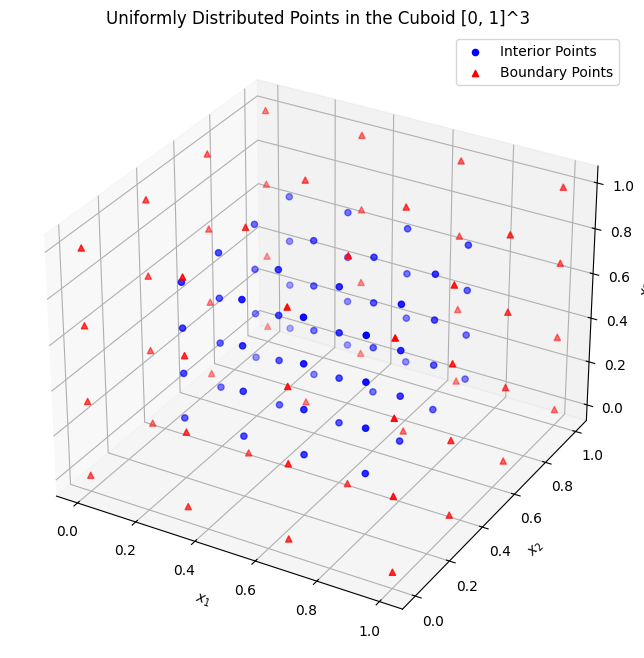

In [ ]:
def generate_uniform_points_cuboid(n_samples_per_side=10, n_samples_per_bnd=8):
    """Generate points uniformly within the unit cuboid [0, 1]^3."""
    x = torch.linspace(0, 1, n_samples_per_side)
    X, Y, Z = torch.meshgrid(x, x, x, indexing='ij')
    points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=1)

    boundary_mask = (points[:, 0] == 0) | (points[:, 0] == 1) | (points[:, 1] == 0) | (points[:, 1] == 1) | (points[:, 2] == 0) | (points[:, 2] == 1)
    Xi = points[~boundary_mask]

    xb = torch.linspace(0, 1, n_samples_per_bnd)
    Xb, Yb, Zb = torch.meshgrid(xb, xb, xb, indexing='ij')
    pts_bnd = torch.stack([Xb.flatten(), Yb.flatten(), Zb.flatten()], dim=1)
    bnd_mask = (pts_bnd[:, 0] == 0) | (pts_bnd[:, 0] == 1) | (pts_bnd[:, 1] == 0) | (pts_bnd[:, 1] == 1) | (pts_bnd[:, 2] == 0) | (pts_bnd[:, 2] == 1)
    Xb = pts_bnd[bnd_mask]

    f_Xi = (-3 * (np.pi ** 2) * torch.sin(np.pi * Xi[:, 0]) * torch.sin(np.pi * Xi[:, 1]) * torch.sin(np.pi * Xi[:, 2])).reshape(-1, 1)
    g_Xb = torch.zeros_like(Xb)[:,:1]

    return Xi, Xb, f_Xi, g_Xb


n_samples_per_side = 6
n_samples_per_bnd = 4
Xi, Xb, f_Xi, g_Xb = generate_uniform_points_cuboid(n_samples_per_side=n_samples_per_side, n_samples_per_bnd=n_samples_per_bnd)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xi[:, 0].numpy(), Xi[:, 1].numpy(), Xi[:, 2].numpy(), color='blue', marker='o', label='Interior Points')
ax.scatter(Xb[:, 0].numpy(), Xb[:, 1].numpy(), Xb[:, 2].numpy(), color='red', marker='^', label='Boundary Points')
ax.set_title('Uniformly Distributed Points in the Cuboid [0, 1]^3')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
kernel = RBFKernel2D(init_lengthscale=0.1000, init_variance=0.0621)
operators = PDEBoundaryOperators2D(kernel=kernel)
solver = PosteriorSolver2D(kernel=kernel, operators=operators)

C_full = solver.compute_covariance_matrix(Xi.to(torch.float64), Xb.to(torch.float64))
C_inv = torch.inverse(C_full + 1e-6 * torch.eye(C_full.shape[0]))

y_obs = torch.cat((f_Xi, g_Xb), dim=0).to(torch.float64)

X_1, X_2, _, _ = generate_uniform_points_cuboid(n_samples_per_side=12, n_samples_per_bnd=6)
X_test = torch.cat((X_1, X_2), dim=0).to(torch.float64)

posterior_mean = solver.posterior_mean(X_test, Xi, Xb, C_inv, y_obs).detach()
posterior_cov_full = solver.posterior_covariance(X_test, X_test.clone(), Xi, Xb, C_inv).detach()
posterior_cov = torch.sqrt(torch.diag(posterior_cov_full)).reshape(-1, 1)
print(torch.sum(torch.isnan(posterior_cov)))

tensor(0)


# SDD inference

In [ ]:
torch.manual_seed(1)

du = 1
input_dim = 1
sigma_n = 0.0
T = 1000
B = 21
beta = 0.001
rho = 0.9
r = 0.99
num_epochs = 4000


def train_SDD(N, du, input_dim, sigma_n, T, B, beta, rho, r, num_epochs, C, y):
    print(f"Training SDD with N={N}, batch_size={B}")
    
    tracemalloc.start()
    start_time = time.time()
    
    A_t = torch.zeros(N, du, dtype=torch.float64)
    V_t = torch.zeros(N, du, dtype=torch.float64)
    A_bar_t = torch.zeros(N, du, dtype=torch.float64)
    K_full = (C + 1e-6 * torch.eye(C.shape[0]))
    
    for t in range(num_epochs):
        S = A_t + rho * V_t
        It = torch.randint(0, N, (min(B, N),))
        G_t = torch.zeros(N, du, dtype=torch.float64)
        batch_size_actual = len(It)
        G_t[It] = (N / batch_size_actual) * K_full[It] @ S - y[It]
        V_t = rho * V_t - beta * G_t
        A_t += V_t
        A_bar_t = r * A_t + (1 - r) * A_bar_t

        if t % 1000 == 0 or t == num_epochs - 1:
            pred = K_full @ A_t
            loss_term1 = 0.5 * torch.norm(y - pred) ** 2
            At_K_At = torch.sum(A_t * (K_full @ A_t))
            loss_term2 = (sigma_n / 2) * At_K_At
            L_t = loss_term1 + loss_term2
            
            current, peak = tracemalloc.get_traced_memory()
            elapsed_time = time.time() - start_time
            print(f"Step {t}, Loss: {L_t.item():.6e}, Time: {elapsed_time:.2f}s, Memory: {current/1024/1024:.2f}MB")
    
    final_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f"Training completed in {final_time:.2f}s, Peak memory: {peak/1024/1024:.2f}MB")
    
    return A_bar_t

In [ ]:
N = C_full.shape[0]
print(f"Actual data size N = {N}")

with torch.no_grad():
    C_full_jitter = C_full + 1e-6 * torch.eye(C_full.shape[0])
    A_approx = train_SDD(N, du, input_dim, sigma_n, T, B, beta, rho, r, num_epochs, C_full_jitter, y_obs.reshape(-1, 1))

In [ ]:
torch.manual_seed(0)

with torch.no_grad():
    C_full_jitter = C_full + 1e-6 * torch.eye(C_full.shape[0])
    cov_vec = solver.compute_covariance_vector(X_test, Xi, Xb).detach()
    N_actual = C_full.shape[0]
    print(f"Computing variance with N_actual = {N_actual}, cov_vec.shape = {cov_vec.shape}")
    A_approx_var = train_SDD(N_actual, cov_vec.shape[0], input_dim, sigma_n, T, B, beta, rho, r, num_epochs, C_full_jitter, cov_vec.T)

Computing variance with N_actual = 120, cov_vec.shape = torch.Size([1152, 120])
Training SDD with N=120, batch_size=32
Step 0, Loss: 6.065300e+11, Time: 0.00s, Memory: 0.14MB
Step 1000, Loss: nan, Time: 1.90s, Memory: 0.14MB
Step 2000, Loss: nan, Time: 3.40s, Memory: 0.14MB
Step 3000, Loss: nan, Time: 4.58s, Memory: 0.14MB
Step 3999, Loss: nan, Time: 5.81s, Memory: 0.14MB
Training completed in 5.81s, Peak memory: 0.15MB


In [ ]:
posterior_mean_sdd = solver.posterior_mean_sdd(X_test, Xi, Xb, A_approx).detach()
posterior_cov_sdd = solver.posterior_covariance_sdd(X_test, X_test.clone(), cov_vec, A_approx_var).detach()
posterior_cov_sdd_sqrt = torch.sqrt(torch.diag(posterior_cov_sdd)).reshape(-1, 1)
print(f"SDD predictions computed. NaN count: {torch.sum(torch.isnan(posterior_cov_sdd_sqrt))}")

SDD predictions computed. NaN count: 1152


In [ ]:
# # Define the log-likelihood function
# def log_likelihood(kernel, Xi, Xb, y_obs):
#     # Compute the full covariance matrix using the current kernel parameters
#     solver = PosteriorSolver2D(kernel=kernel, operators=PDEBoundaryOperators2D(kernel=kernel))
#     C_full = solver.compute_covariance_matrix(Xi.requires_grad_(True), Xb.requires_grad_(True))

#     # Add jitter for numerical stability
#     C_full += 1e-6 * torch.eye(C_full.shape[0])

#     # Compute the inverse of the covariance matrix
#     C_inv = torch.inverse(C_full)

#     # Compute log determinant of the covariance matrix
#     log_det_C = torch.logdet(C_full)

#     # Compute the log-likelihood
#     n = y_obs.shape[0]
#     ll = -0.5 * y_obs.T @ C_inv @ y_obs - 0.5 * log_det_C

#     return ll

# # Define ranges for lengthscale and variance for grid search
# lengthscale_values = torch.linspace(0.1, 19, steps=20)  # Adjust range and steps as needed
# variance_values = torch.linspace(0.01, 1, steps=20)   # Adjust range and steps as needed

# # Store the best parameters and the corresponding log-likelihood
# best_lengthscale = None
# best_variance = None
# best_log_likelihood = -float('inf')

# # Perform grid search
# for lengthscale in lengthscale_values:
#     for variance in variance_values:
#         # Initialize kernel with current parameters
#         kernel = RBFKernel2D(init_lengthscale=lengthscale.item(), init_variance=variance.item())

#         # Compute log-likelihood for the current set of hyperparameters
#         ll = log_likelihood(kernel, Xi.to(torch.float64), Xb.to(torch.float64), y_obs)

#         # Check if this is the best log-likelihood so far
#         if ll.item() > best_log_likelihood:
#             best_log_likelihood = ll.item()
#             best_lengthscale = lengthscale.item()
#             best_variance = variance.item()

#         print(f"Lengthscale: {lengthscale.item()}, Variance: {variance.item()}, Log-Likelihood: {ll.item()}")

# # Output the best hyperparameters and their log-likelihood
# print(f"\nBest Hyperparameters: Lengthscale = {best_lengthscale}, Variance = {best_variance}")
# print(f"Best Log-Likelihood: {best_log_likelihood}")

Lengthscale: 0.10000000149011612, Variance: 0.009999999776482582, Log-Likelihood: -552.5481160065847
Lengthscale: 0.10000000149011612, Variance: 0.06210526078939438, Log-Likelihood: -66.11398115871509
Lengthscale: 0.10000000149011612, Variance: 0.11421052366495132, Log-Likelihood: -125.99120613681401
Lengthscale: 0.10000000149011612, Variance: 0.16631579399108887, Log-Likelihood: -168.15780436304257
Lengthscale: 0.10000000149011612, Variance: 0.2184210568666458, Log-Likelihood: -199.76165820243872
Lengthscale: 0.10000000149011612, Variance: 0.27052628993988037, Log-Likelihood: -224.90640207904175
Lengthscale: 0.10000000149011612, Variance: 0.3226315677165985, Log-Likelihood: -245.74949481106526
Lengthscale: 0.10000000149011612, Variance: 0.37473684549331665, Log-Likelihood: -263.53497265435016
Lengthscale: 0.10000000149011612, Variance: 0.4268420934677124, Log-Likelihood: -279.0395221293023
Lengthscale: 0.10000000149011612, Variance: 0.47894734144210815, Log-Likelihood: -292.7788965287

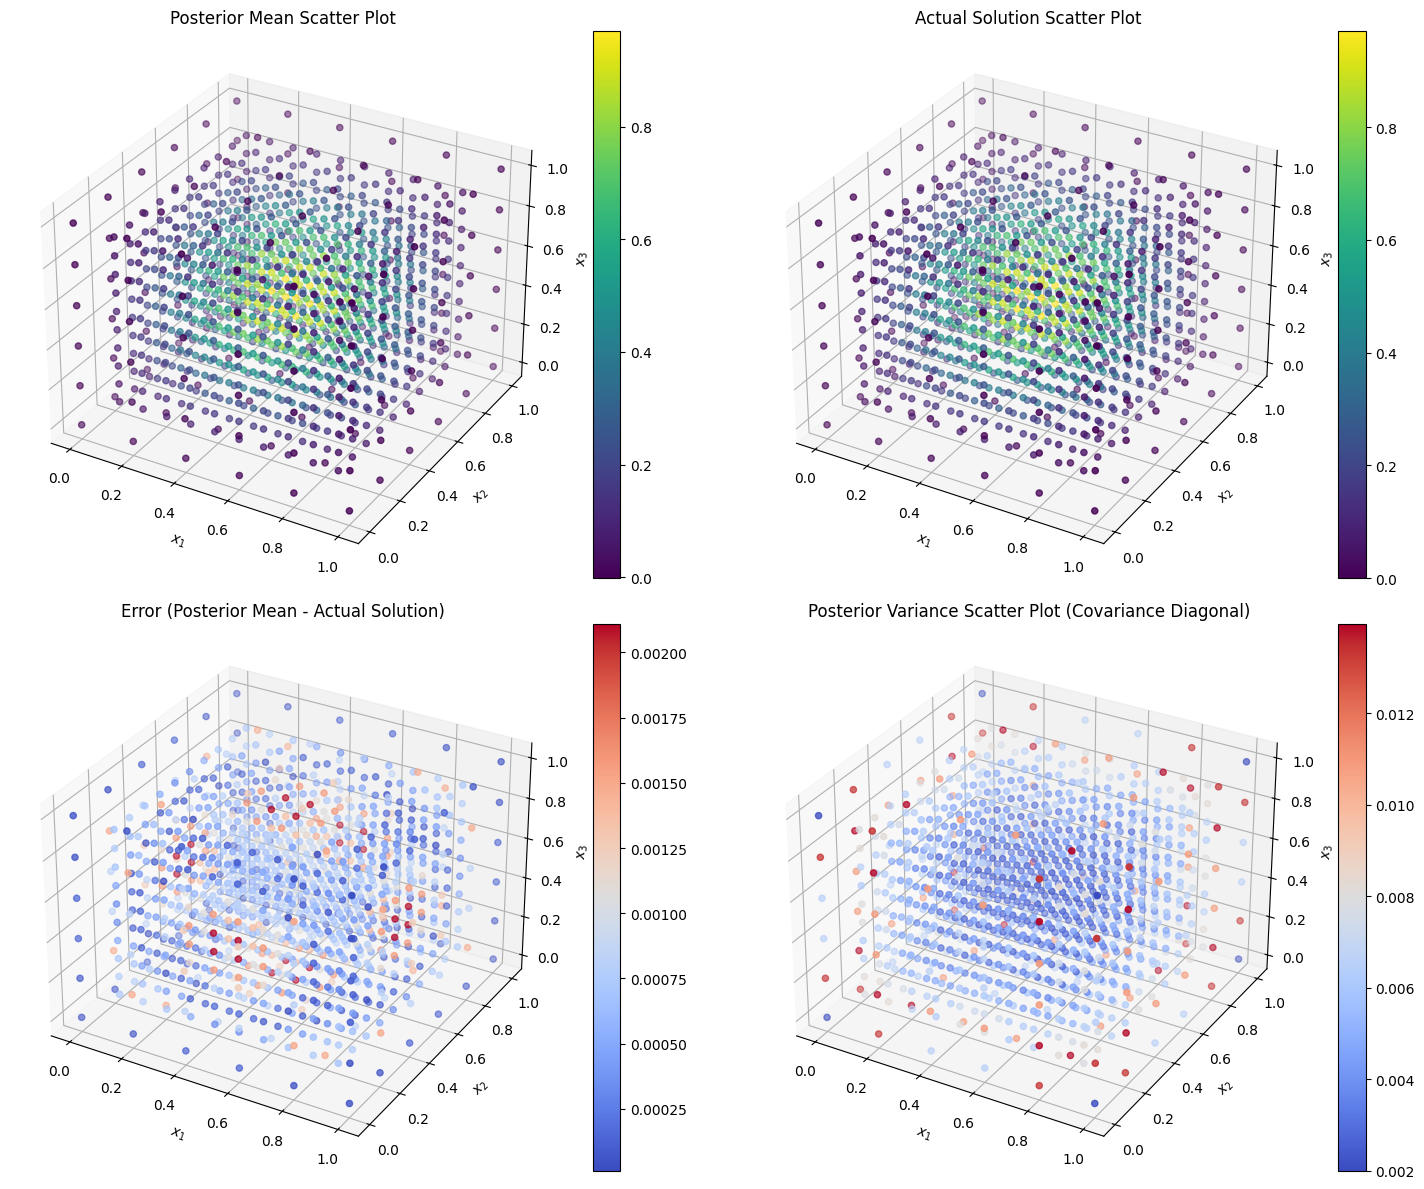

In [ ]:
x1 = X_test[:, 0].detach().numpy()
x2 = X_test[:, 1].detach().numpy()
x3 = X_test[:, 2].detach().numpy()
posterior_mean_np = posterior_mean.detach().numpy().reshape(-1)
posterior_cov_np = posterior_cov.detach().numpy().reshape(-1)

actual_solution = np.sin(np.pi * x1) * np.sin(np.pi * x2) * np.sin(np.pi * x3)
error = np.abs(posterior_mean_np - actual_solution)

fig, axes = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': '3d'})

scat_posterior = axes[0, 0].scatter(x1, x2, x3, c=posterior_mean_np, cmap='viridis')
fig.colorbar(scat_posterior, ax=axes[0, 0])
axes[0, 0].set_title('Posterior Mean Scatter Plot')
axes[0, 0].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('$x_2$')
axes[0, 0].set_zlabel('$x_3$')

scat_actual = axes[0, 1].scatter(x1, x2, x3, c=actual_solution, cmap='viridis')
fig.colorbar(scat_actual, ax=axes[0, 1])
axes[0, 1].set_title('Actual Solution Scatter Plot')
axes[0, 1].set_xlabel('$x_1$')
axes[0, 1].set_ylabel('$x_2$')
axes[0, 1].set_zlabel('$x_3$')

scat_error = axes[1, 0].scatter(x1, x2, x3, c=error, cmap='coolwarm')
fig.colorbar(scat_error, ax=axes[1, 0])
axes[1, 0].set_title('Error (Posterior Mean - Actual Solution)')
axes[1, 0].set_xlabel('$x_1$')
axes[1, 0].set_ylabel('$x_2$')
axes[1, 0].set_zlabel('$x_3$')

scat_variance = axes[1, 1].scatter(x1, x2, x3, c=2 * posterior_cov_np, cmap='coolwarm')
fig.colorbar(scat_variance, ax=axes[1, 1])
axes[1, 1].set_title('Posterior Variance Scatter Plot (Covariance Diagonal)')
axes[1, 1].set_xlabel('$x_1$')
axes[1, 1].set_ylabel('$x_2$')
axes[1, 1].set_zlabel('$x_3$')

plt.tight_layout()
plt.show()

In [12]:
np.mean(error)/np.mean(np.abs(actual_solution))

np.float64(0.002241191646901106)